In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass

@dataclass
class SimulationResult:
    """Class to store simulation results"""
    trajectories: np.ndarray
    outcomes: List[str]
    reaction_times: List[float]
    decision_times: List[int]

class DriftDiffusionModel:
    """
    A class to simulate and analyze the drift-diffusion model for perceptual decision making.
    
    The model follows: dx/dt = (I_A - I_B) + σ*η(t)
    where x is the decision variable, I_A and I_B are decision inputs,
    η(t) is Gaussian white noise, and σ is noise magnitude.
    """
    
    def __init__(self, I_A: float, I_B: float, sigma: float, mu: float, dt: float = 0.1):
        """
        Initialize the drift-diffusion model.
        
        Args:
            I_A: Decision input A
            I_B: Decision input B  
            sigma: Noise magnitude
            mu: Decision threshold (absolute value)
            dt: Time step
        """
        self.I_A = I_A
        self.I_B = I_B
        self.sigma = sigma
        self.mu = mu
        self.dt = dt
        self.evidence = I_A - I_B
        
    def simulate_single_trial(self, max_steps: int = 10000, x0: float = 0.0) -> Tuple[np.ndarray, str, float, int]:
        """
        Simulate a single trial of the drift-diffusion process.
        
        Args:
            max_steps: Maximum number of time steps
            x0: Initial condition
            
        Returns:
            trajectory: Array of decision variable values over time
            outcome: 'A', 'B', or 'No decision'
            reaction_time: Time to reach decision
            decision_step: Step at which decision was made
        """
        x = np.zeros(max_steps)
        x[0] = x0
        
        for t in range(1, max_steps):
            # Generate noise
            noise = np.random.normal(0, 1)
            
            # Update decision variable
            dx = (self.I_A - self.I_B) * self.dt + self.sigma * np.sqrt(self.dt) * noise
            x[t] = x[t-1] + dx
            
            # Check for decision
            if x[t] >= self.mu:
                return x[:t+1], 'A', t * self.dt, t
            elif x[t] <= -self.mu:
                return x[:t+1], 'B', t * self.dt, t
        
        return x, 'No decision', max_steps * self.dt, max_steps
    
    def simulate_multiple_trials(self, n_trials: int, max_steps: int = 10000, x0: float = 0.0) -> SimulationResult:
        """
        Simulate multiple trials of the drift-diffusion process.
        
        Args:
            n_trials: Number of trials to simulate
            max_steps: Maximum number of time steps per trial
            x0: Initial condition
            
        Returns:
            SimulationResult containing all trajectories and outcomes
        """
        trajectories = []
        outcomes = []
        reaction_times = []
        decision_times = []
        
        for _ in range(n_trials):
            traj, outcome, rt, dt = self.simulate_single_trial(max_steps, x0)
            trajectories.append(traj)
            outcomes.append(outcome)
            reaction_times.append(rt)
            decision_times.append(dt)
        
        return SimulationResult(trajectories, outcomes, reaction_times, decision_times)
    
    def count_outcomes(self, outcomes: List[str]) -> Dict[str, int]:
        """Count the number of each type of outcome."""
        return {
            'A': outcomes.count('A'),
            'B': outcomes.count('B'),
            'No decision': outcomes.count('No decision')
        }
    
    def plot_trajectories(self, trajectories: List[np.ndarray], title: str = "Drift-Diffusion Trajectories"):
        """Plot multiple trajectories."""
        plt.figure(figsize=(12, 8))
        
        for i, traj in enumerate(trajectories):
            time_points = np.arange(len(traj)) * self.dt
            plt.plot(time_points, traj, alpha=0.7, label=f'Trial {i+1}')
        
        plt.axhline(y=self.mu, color='red', linestyle='--', label=f'Threshold A (+{self.mu})')
        plt.axhline(y=-self.mu, color='red', linestyle='--', label=f'Threshold B (-{self.mu})')
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        plt.xlabel('Time')
        plt.ylabel('Decision Variable x(t)')
        plt.title(title)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def plot_reaction_time_distribution(self, reaction_times: List[float], evidence: float, bins: int = 30):
        """Plot reaction time distribution."""
        plt.figure(figsize=(10, 6))
        
        # Filter out max reaction times (no decision cases)
        filtered_rt = [rt for rt in reaction_times if rt < 1000]  # Assuming max_steps * dt = 1000
        
        # Create histogram
        plt.hist(filtered_rt, bins=bins, alpha=0.7, density=True, color='skyblue', edgecolor='black')
        
        # Add KDE plot
        if len(filtered_rt) > 0:
            sns.kdeplot(filtered_rt, color='red', linewidth=2)
        
        plt.xlabel('Reaction Time')
        plt.ylabel('Density')
        plt.title(f'Reaction Time Distribution (Evidence E = {evidence})')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        return filtered_rt

class ParameterAnalysis:
    """Class for analyzing how different parameters affect the drift-diffusion model."""
    
    @staticmethod
    def analyze_threshold_variation(mu_values: np.ndarray, I_A: float = 0.95, I_B: float = 1.0, 
                                  sigma: float = 7.0, n_trials: int = 100, max_steps: int = 10000) -> Tuple[List[int], List[int]]:
        """Analyze how threshold μ affects decision outcomes."""
        outcomes_A = []
        outcomes_B = []
        
        for mu in mu_values:
            model = DriftDiffusionModel(I_A, I_B, sigma, mu)
            results = model.simulate_multiple_trials(n_trials, max_steps=max_steps)
            counts = model.count_outcomes(results.outcomes)
            outcomes_A.append(counts['A'])
            outcomes_B.append(counts['B'])
        
        return outcomes_A, outcomes_B
    
    @staticmethod
    def analyze_evidence_variation(evidence_values: np.ndarray, I_B: float = 1.0, 
                                 sigma: float = 7.0, mu: float = 20.0, n_trials: int = 100, max_steps: int = 10000) -> Tuple[List[int], List[int]]:
        """Analyze how evidence E = I_A - I_B affects decision outcomes."""
        outcomes_A = []
        outcomes_B = []
        
        for E in evidence_values:
            I_A = I_B + E
            model = DriftDiffusionModel(I_A, I_B, sigma, mu)
            results = model.simulate_multiple_trials(n_trials, max_steps=max_steps)
            counts = model.count_outcomes(results.outcomes)
            outcomes_A.append(counts['A'])
            outcomes_B.append(counts['B'])
        
        return outcomes_A, outcomes_B
    
    @staticmethod
    def plot_parameter_analysis(param_values: np.ndarray, outcomes_A: List[int], outcomes_B: List[int], 
                              param_name: str, param_symbol: str):
        """Plot parameter analysis results."""
        plt.figure(figsize=(10, 6))
        plt.plot(param_values, outcomes_A, 'bo-', label='Outcomes A', linewidth=2, markersize=6)
        plt.plot(param_values, outcomes_B, 'ro-', label='Outcomes B', linewidth=2, markersize=6)
        plt.xlabel(f'{param_name} ({param_symbol})')
        plt.ylabel('Number of Outcomes')
        plt.title(f'Decision Outcomes vs {param_name}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

DRIFT-DIFFUSION MODEL ANALYSIS

1.1 Simulating 10 trajectories...
Trial 1: B, Reaction time: 4.5
Trial 2: A, Reaction time: 16.7
Trial 3: A, Reaction time: 16.7
Trial 4: B, Reaction time: 9.4
Trial 5: B, Reaction time: 7.2
Trial 6: A, Reaction time: 7.9
Trial 7: B, Reaction time: 5.2
Trial 8: A, Reaction time: 15.1
Trial 9: A, Reaction time: 6.3
Trial 10: A, Reaction time: 2.0


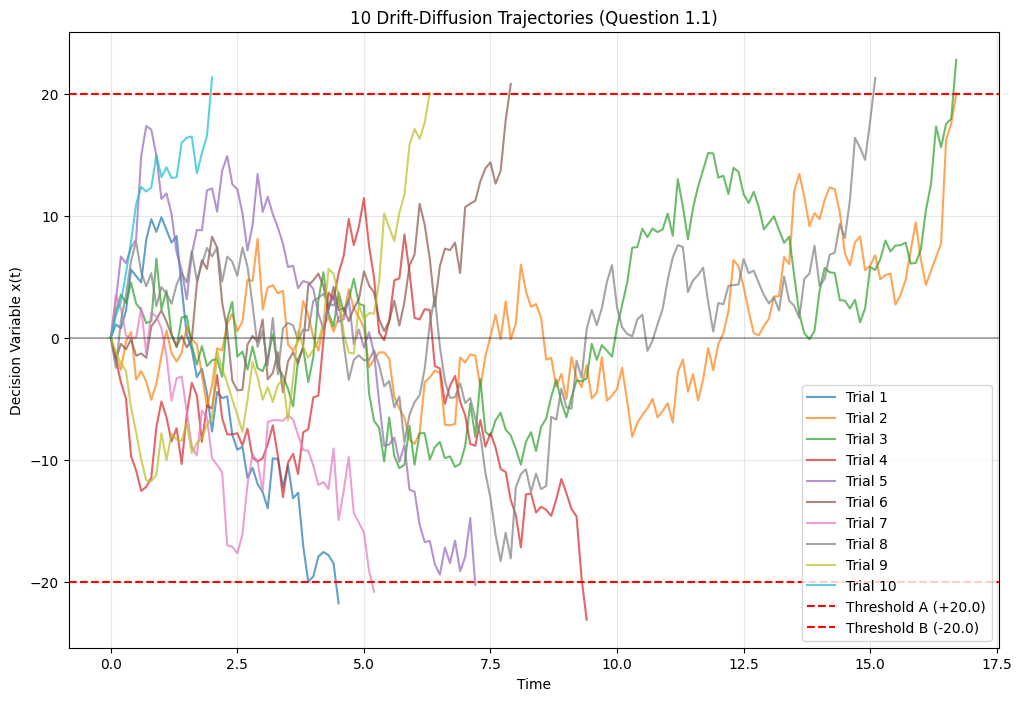

In [24]:
"""Main function to run all homework questions."""

print("=" * 60)
print("DRIFT-DIFFUSION MODEL ANALYSIS")
print("=" * 60)

# Question 1.1: Simulate and plot 10 trajectories
print("\n1.1 Simulating 10 trajectories...")
model = DriftDiffusionModel(I_A=0.95, I_B=1.0, sigma=7.0, mu=20.0)

# Simulate 10 trajectories
np.random.seed(42)  # For reproducibility
trajectories_10 = []
for i in range(10):
    traj, outcome, rt, dt = model.simulate_single_trial(max_steps=10000, x0=0.0)
    trajectories_10.append(traj)
    print(f"Trial {i+1}: {outcome}, Reaction time: {rt:.1f}")

model.plot_trajectories(trajectories_10, "10 Drift-Diffusion Trajectories (Question 1.1)")

In [69]:

# Question 1.2: Simulate 1000 times and store outcomes
print("\n1.2 Simulating 1000 trials...")
results_1000 = model.simulate_multiple_trials(n_trials=1000, max_steps=1000, x0=0.0)
counts = model.count_outcomes(results_1000.outcomes)

print(f"Results from 1000 simulations:")
print(f"Decision A: {counts['A']} times")
print(f"Decision B: {counts['B']} times") 
print(f"No decision: {counts['No decision']} times")


1.2 Simulating 1000 trials...
Results from 1000 simulations:
Decision A: 506 times
Decision B: 494 times
No decision: 0 times



1.3 Parameter variation analysis...
Analyzing threshold variation...


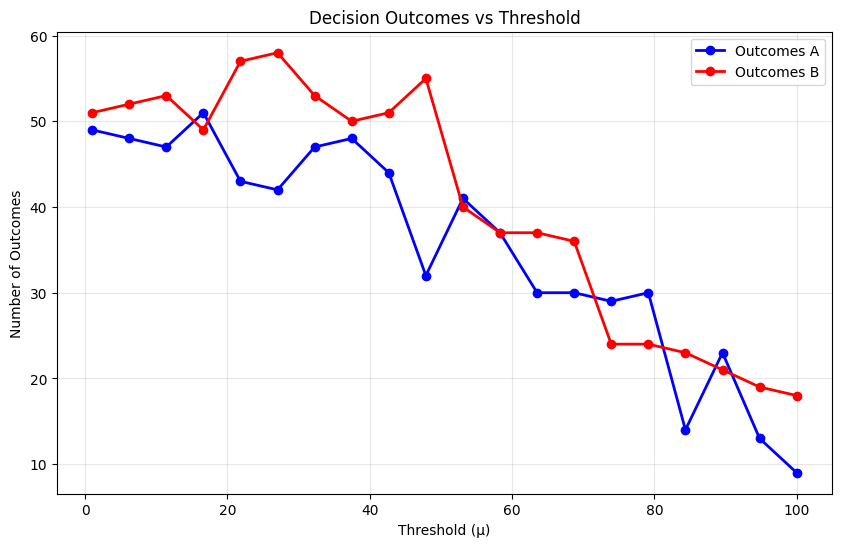

Threshold analysis: Higher thresholds require more evidence to make decisions,
leading to fewer decisions overall but potentially more accurate ones.


In [62]:
# Question 1.3: Parameter variation
print("\n1.3 Parameter variation analysis...")

# Vary threshold μ
print("Analyzing threshold variation...")
mu_values = np.linspace(1, 100, 20)
outcomes_A_mu, outcomes_B_mu = ParameterAnalysis.analyze_threshold_variation(
    mu_values, I_A=0.95, I_B=1.0, sigma=7.0, n_trials=100, max_steps=1000
)
ParameterAnalysis.plot_parameter_analysis(mu_values, outcomes_A_mu, outcomes_B_mu, 
                                        "Threshold", "μ")

print("Threshold analysis: Higher thresholds require more evidence to make decisions,")
print("leading to fewer decisions overall but potentially more accurate ones.")



Analyzing evidence variation...


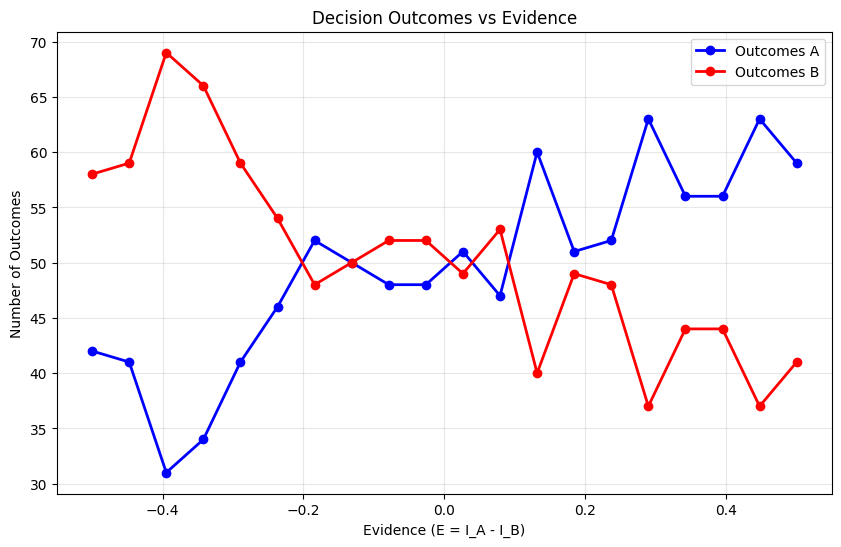

Evidence analysis: Positive evidence favors decision A, negative favors B.
The bias in the drift term determines which decision is more likely.


In [67]:

# Vary evidence E
print("\nAnalyzing evidence variation...")
evidence_values = np.linspace(-0.5, 0.5, 20)
outcomes_A_E, outcomes_B_E = ParameterAnalysis.analyze_evidence_variation(
    evidence_values, I_B=1.0, sigma=7.0, mu=20.0, n_trials=100, max_steps=10000
)
ParameterAnalysis.plot_parameter_analysis(evidence_values, outcomes_A_E, outcomes_B_E,
                                        "Evidence", "E = I_A - I_B")

print("Evidence analysis: Positive evidence favors decision A, negative favors B.")
print("The bias in the drift term determines which decision is more likely.")



1.4 Reaction time distribution analysis...

Analyzing reaction times for evidence E = 0...


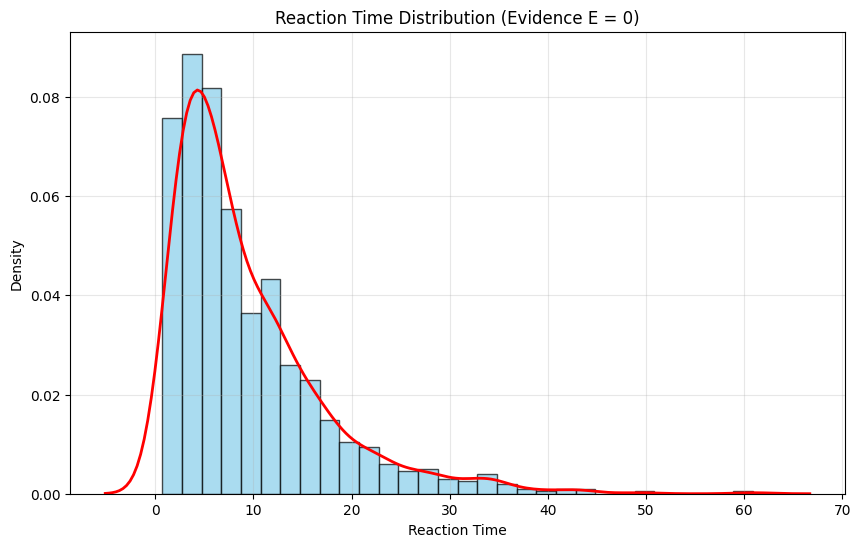

Mean reaction time: 9.23
Std reaction time: 7.70
Decisions made: 1000/1000

Analyzing reaction times for evidence E = 0.1...


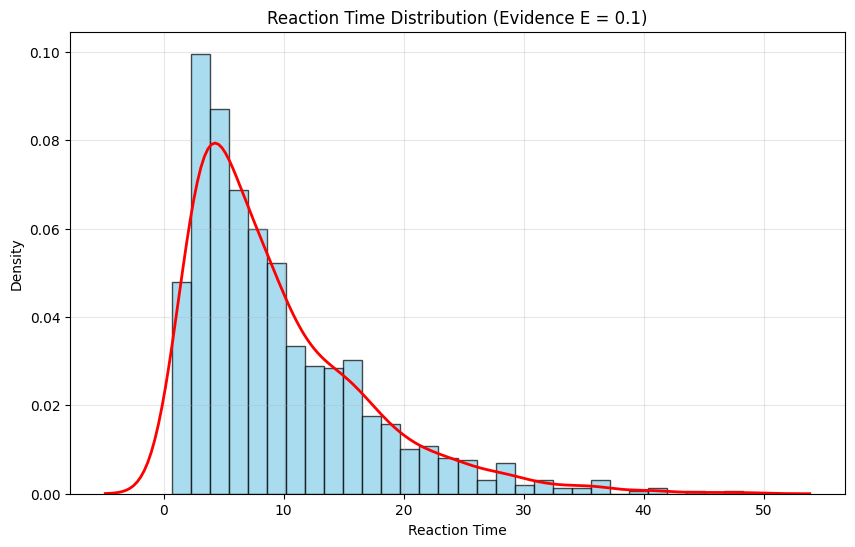

Mean reaction time: 9.49
Std reaction time: 7.37
Decisions made: 1000/1000

Analyzing reaction times for evidence E = 5...


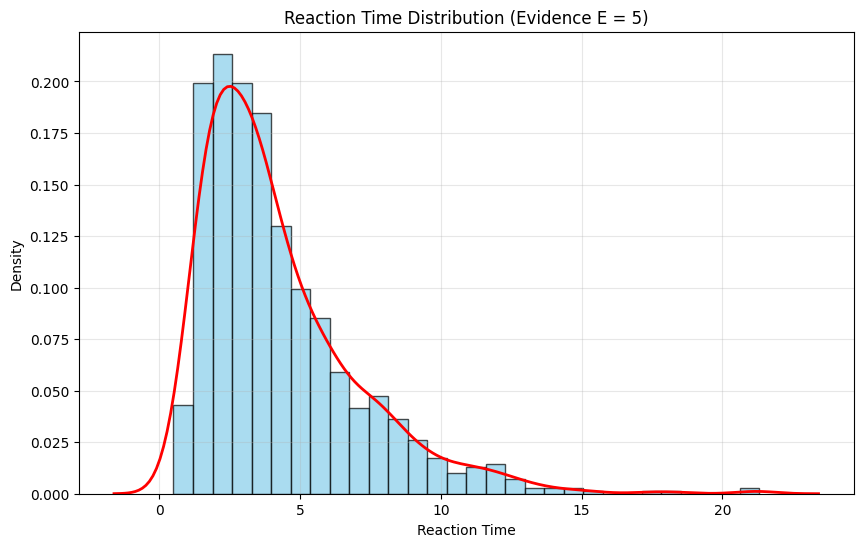

Mean reaction time: 4.24
Std reaction time: 2.80
Decisions made: 1000/1000

Reaction time analysis:
- Higher evidence leads to faster decisions (shorter reaction times)
- Lower evidence leads to more variable reaction times
- Zero evidence shows the most symmetric and variable distribution


In [59]:

# Question 1.4: Reaction time distributions
print("\n1.4 Reaction time distribution analysis...")
evidence_levels = [0, 0.1, 5]

for E in evidence_levels:
    print(f"\nAnalyzing reaction times for evidence E = {E}...")
    I_A = 1.0 + E
    model_rt = DriftDiffusionModel(I_A=I_A, I_B=1.0, sigma=7.0, mu=20.0)
    results_rt = model_rt.simulate_multiple_trials(n_trials=1000, max_steps=1000, x0=0.0)
    
    filtered_rt = model_rt.plot_reaction_time_distribution(results_rt.reaction_times, E)
    
    if len(filtered_rt) > 0:
        print(f"Mean reaction time: {np.mean(filtered_rt):.2f}")
        print(f"Std reaction time: {np.std(filtered_rt):.2f}")
        print(f"Decisions made: {len(filtered_rt)}/1000")

print("\nReaction time analysis:")
print("- Higher evidence leads to faster decisions (shorter reaction times)")
print("- Lower evidence leads to more variable reaction times")
print("- Zero evidence shows the most symmetric and variable distribution")